In [1]:
! pip install numpy pandas scikit-learn matplotlib xgboost gensim fuzzywuzzy\[speedup\] nltk pyemd

## Imports

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb

from nltk import word_tokenize, download
from nltk.corpus import stopwords
from tqdm import tqdm_notebook
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import skew, kurtosis
from scipy.spatial.distance import cosine, cityblock, jaccard, canberra, euclidean, minkowski, braycurtis
from gensim.models import KeyedVectors
from fuzzywuzzy import fuzz

## Train data loading and Word2Vec model loading

You can download the Word2Vec pre-trained corpus at this link https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit

In [2]:
download('punkt')
download('stopwords')

train_df = pd.read_csv('../assist_material/datasets/extracted/q2b/train.csv', sep=',')
train_df.columns = ['id', 'q1', 'q2', 'is_dup']

norm_model = KeyedVectors.load_word2vec_format('./word2Vec/GoogleNews-vectors-negative300.bin.gz', binary=True)
norm_model.init_sims(replace=True)

[nltk_data] Downloading package punkt to /home/vangelis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/vangelis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Checking distribution of the train elements

The below bar plot shows us how umbalanced is the train dataset. Class 1 (duplicate) has ~70k less
documents than class 0 (no-duplicate)

<AxesSubplot:xlabel='is_dup'>

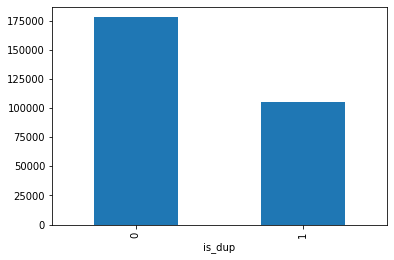

In [3]:
train_df.groupby("is_dup")['id'].count().plot.bar()

## Feature Engineering

The methods below generate metrics and stats of each question pairs in order to create numerical 
data.

In [19]:
def norm_wmd(q1, q2):
    """
    ~~ Word2Vec ~~
    Word Mover’s Distance between two questions. WMD use word embeddings to calculate the distance so that it
    can calculate even though there is no common word. The assumption is that similar words should have similar vectors.
    :param q1: Question 1
    :param q2: Question 2
    :return: Word Mover’s Distance between two questions
    """
    q1 = str(q1).lower().split()
    q2 = str(q2).lower().split()
    stop_words = stopwords.words('english')
    q1 = [w for w in q1 if w not in stop_words]
    q2 = [w for w in q2 if w not in stop_words]
    return norm_model.wmdistance(q1, q2)


def sent2vec(s):
    """
    Convert sentence to vector using Word2Vec model
    :param q1: Question 1
    :param q2: Question 2
    :return: Vectorized sentences
    """
    words = str(s).lower()
    words = word_tokenize(words)
    stop_words = stopwords.words('english')
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(norm_model[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    return v / np.sqrt((v ** 2).sum())


def feature_engineering(df):
    """
    Create features from the given data
    :param df: The dataframe that contains questions
    :return: None
    """
    df['len_q1'] = df.q1.apply(lambda x: len(str(x)))
    df['len_q2'] = df.q2.apply(lambda x: len(str(x)))
    df['diff_len'] = df.len_q1 - df.len_q2
    df['len_char_q1'] = df.q1.apply(lambda x: len(''.join(set(str(x).replace(' ', '')))))
    df['len_char_q2'] = df.q2.apply(lambda x: len(''.join(set(str(x).replace(' ', '')))))
    df['len_word_q1'] = df.q1.apply(lambda x: len(str(x).split()))
    df['len_word_q2'] = df.q2.apply(lambda x: len(str(x).split()))
    df['common_words'] = df.apply(lambda x: len(set(str(x['q1']).lower().split()).intersection(set(str(x['q2']).lower()
                                                                                                   .split()))), axis=1)
    df['fuzz_ratio'] = df.apply(lambda x: fuzz.ratio(str(x['q1']), str(x['q2'])), axis=1)
    df['fuzz_partial_ratio'] = df.apply(lambda x: fuzz.partial_ratio(str(x['q1']), str(x['q2'])), axis=1)
    df['fuzz_partial_token_set_ratio'] = df.apply(lambda x: fuzz.partial_token_set_ratio(str(x['q1']), str(x['q2'])),
                                                  axis=1)
    df['fuzz_partial_token_sort_ratio'] = df.apply(lambda x: fuzz.partial_token_sort_ratio(str(x['q1']), str(x['q2'])),
                                                   axis=1)
    df['fuzz_token_set_ratio'] = df.apply(lambda x: fuzz.token_set_ratio(str(x['q1']), str(x['q2'])), axis=1)
    df['fuzz_token_sort_ratio'] = df.apply(lambda x: fuzz.token_sort_ratio(str(x['q1']), str(x['q2'])), axis=1)



def distances(df):
    """
    Calcuate distances between the questions
    :param df: The dataframe
    :return: None
    """
    
    q1_vectors = np.zeros((df.shape[0], 300))
    for i, q in enumerate(tqdm_notebook(df.q1.values)):
        q1_vectors[i, :] = sent2vec(q)

    q2_vectors  = np.zeros((df.shape[0], 300))
    for i, q in enumerate(tqdm_notebook(df.q2.values)):
        q2_vectors[i, :] = sent2vec(q)
    df['norm_wmd'] = df.apply(lambda x: norm_wmd(x['q1'], x['q2']), axis=1)
    df['cosine_distance'] = [cosine(x, y) for (x, y) in zip(np.nan_to_num(q1_vectors),
                                                            np.nan_to_num(q2_vectors))]
    df['cityblock_distance'] = [cityblock(x, y) for (x, y) in zip(np.nan_to_num(q1_vectors),
                                                                  np.nan_to_num(q2_vectors))]
    df['jaccard_distance'] = [jaccard(x, y) for (x, y) in zip(np.nan_to_num(q1_vectors),
                                                              np.nan_to_num(q2_vectors))]
    df['canberra_distance'] = [canberra(x, y) for (x, y) in zip(np.nan_to_num(q1_vectors),
                                                                np.nan_to_num(q2_vectors))]
    df['euclidean_distance'] = [euclidean(x, y) for (x, y) in zip(np.nan_to_num(q1_vectors),
                                                                  np.nan_to_num(q2_vectors))]
    df['minkowski_distance'] = [minkowski(x, y, 3) for (x, y) in zip(np.nan_to_num(q1_vectors),
                                                                     np.nan_to_num(q2_vectors))]
    df['braycurtis_distance'] = [braycurtis(x, y) for (x, y) in zip(np.nan_to_num(q1_vectors),
                                                                    np.nan_to_num(q2_vectors))]
    df['skew_q1vec'] = [skew(x) for x in np.nan_to_num(q1_vectors)]
    df['skew_q2vec'] = [skew(x) for x in np.nan_to_num(q2_vectors)]
    df['kur_q1vec'] = [kurtosis(x) for x in np.nan_to_num(q1_vectors)]
    df['kur_q2vec'] = [kurtosis(x) for x in np.nan_to_num(q2_vectors)]

## Apply feature engineering to Train dataset

In [ ]:
feature_engineering(train_df)
distances(train_df)

train_df.drop(['q1', 'q2'], axis=1, inplace=True)
train_df = train_df[pd.notnull(train_df['cosine_distance'])]
train_df = train_df[pd.notnull(train_df['jaccard_distance'])]

X = train_df.loc[:, train_df.columns != 'is_dup']
y = train_df.loc[:, train_df.columns == 'is_dup']

## XGBoost model

In [11]:
xgb_model = xgb.XGBClassifier(max_depth=80, n_estimators=500, learning_rate=0.1, colsample_bytree=0.7, gamma=0,
                              reg_alpha=0.4, objective='binary:logistic', eta=0.3, subsample=0.8, use_label_encoder=False)


## Random Forest model

In [12]:
rf_model = RandomForestClassifier(n_estimators=500, max_features='sqrt', n_jobs=4)

## 5-fold Stratified Validation

In [13]:
skf = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)

scores_xgb = cross_validate(xgb_model, X, y.values.ravel(),
                            scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'],
                            cv=skf,
                            return_train_score=False)
print(scores_xgb)

# scores_rf = cross_validate(rf_model, X, y.values.ravel(),
#                           scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'],
#                           cv=skf,
#                           return_train_score=False)
# print(scores_rf)

[22:29:03] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:35:36] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:42:37] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:49:38] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

## Stats table

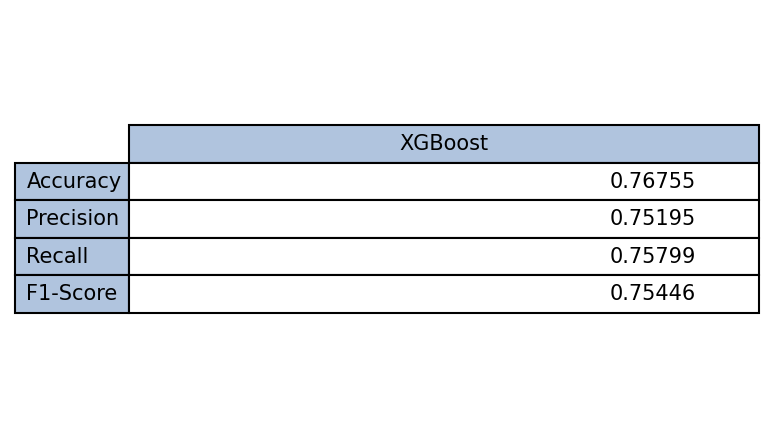

In [15]:
data_table = [[np.mean(scores_xgb['test_accuracy'], dtype='float64')],
              [np.mean(scores_xgb['test_precision_macro'], dtype='float64')],
              [np.mean(scores_xgb['test_recall_macro'], dtype='float64')],
              [np.mean(scores_xgb['test_f1_macro'], dtype='float64')]
              ]

cell_text = []
for row in data_table:
    cell_text.append([f'{x:1.5f}' for x in row])

plt.figure(dpi=150)
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.box(on=None)
plt.subplots_adjust(left=0.2, bottom=0.2)

the_table = plt.table(cellText=cell_text,
                      rowLabels=['Accuracy', 'Precision', 'Recall', 'F1-Score'],
                      colLabels=['XGBoost'],
                      colColours=['lightsteelblue'] * 1,
                      rowColours=['lightsteelblue'] * 4,
                      loc='center')
the_table.scale(1, 1.5)
fig = plt.gcf()
plt.show()

## Test set prediction

In [17]:
test_df = pd.read_csv('../assist_material/datasets/extracted/q2b/test_without_labels.csv', sep=',')
test_df.columns = ['id', 'q1', 'q2']

feature_engineering(test_df)
distances(test_df)

test_df.drop(['q1', 'q2'], axis=1, inplace=True)

# If NaN encountered set large distances (0<=dist<=1)
test_df['cosine_distance'] = test_df['cosine_distance'].fillna(0.9)
test_df['jaccard_distance'] = test_df['jaccard_distance'].fillna(0.9)

X_test = test_df

xgb_model.fit(X, y.values.ravel())
y_pred = xgb_model.predict(X_test)

<ipython-input-4-d8b5b70f00d5>:75: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, q in enumerate(tqdm_notebook(df.q1.values)):


  0%|          | 0/121287 [00:00<?, ?it/s]

<ipython-input-4-d8b5b70f00d5>:38: RuntimeWarning: invalid value encountered in double_scalars
  return v / np.sqrt((v ** 2).sum())
<ipython-input-4-d8b5b70f00d5>:79: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, q in enumerate(tqdm_notebook(df.q2.values)):


  0%|          | 0/121287 [00:00<?, ?it/s]

/home/vangelis/.virtualenvs/big-data-analytics/lib/python3.8/site-packages/scipy/spatial/distance.py:728: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/home/vangelis/.virtualenvs/big-data-analytics/lib/python3.8/site-packages/scipy/spatial/distance.py:1186: RuntimeWarning: invalid value encountered in double_scalars
  return l1_diff.sum() / l1_sum.sum()


[23:23:40] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [18]:
prediction = pd.DataFrame(data={'Id': test_df['id'], 'Expected': y_pred}).to_csv('duplicate_predictions.csv', index=False)